<center>
<img src="../../img/ods_stickers.jpg" />
    
## [mlcourse.ai](https://mlcourse.ai) – Open Machine Learning Course 
Author: [Yury Kashnitsky](https://yorko.github.io) (@yorko). Edited by Anna Tarelina (@feuerengel), and Mikhail Korshchikov (@MS4). This material is subject to the terms and conditions of the [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/) license. Free use is permitted for any non-commercial purpose.

# <center>Assignment #2. Fall 2019
## <center> Part 1. Decision trees for classification and regression

**In this assignment, we will find out how a decision tree works in a regression task, then will build and tune classification decision trees for identifying heart diseases.**

Prior to working on the assignment, you'd better check out the corresponding course material:
 1. [Classification, Decision Trees and k Nearest Neighbors](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true), the same as an interactive web-based [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-3-decision-trees-and-knn) 
 2. Ensembles:
  - [Bagging](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part1_bagging.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-1-bagging)
  - [Random Forest](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part2_random_forest.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-2-random-forest)
  - [Feature Importance](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic05_ensembles_random_forests/topic5_part3_feature_importance.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-5-ensembles-part-3-feature-importance)
 3. - [Gradient boosting](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic10_boosting/topic10_gradient_boosting.ipynb?flush_cache=true), the same as a [Kaggle Kernel](https://www.kaggle.com/kashnitsky/topic-10-gradient-boosting) 
   - Logistic regression, Random Forest, and LightGBM in the "Kaggle Forest Cover Type Prediction" competition: [Kernel](https://www.kaggle.com/kashnitsky/topic-10-practice-with-logit-rf-and-lightgbm) 
 4. You can also practice with demo assignments, which are simpler and already shared with solutions:
  - "Decision trees with a toy task and the UCI Adult dataset": [assignment](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees) + [solution](https://www.kaggle.com/kashnitsky/a3-demo-decision-trees-solution)
  - "Logistic Regression and Random Forest in the credit scoring problem": [assignment](https://www.kaggle.com/kashnitsky/assignment-5-logit-and-rf-for-credit-scoring) + [solution](https://www.kaggle.com/kashnitsky/a5-demo-logit-and-rf-for-credit-scoring-sol)
 5. There are also 7 video lectures on trees, forests, boosting and their applications: [mlcourse.ai/lectures](https://mlcourse.ai/lectures) 

### Your task is to:
 1. write code and perform computations in the cells below
 2. choose answers in the [webform](https://docs.google.com/forms/d/1-xvxl0xjV4voDYIbcCxxpAc_pjcWEpnLQ9kaKLHwXsA). Solutions will be shared only with those who've filled in this form 
 
### <center> Deadline for A2: 2019 October 6, 20:59 CET (London time)

In [5]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor

## 1. Decision trees for regression: a toy example

Let's consider the following one-dimensional regression problem. We need to build a function $\large a(x)$ to approximate the dependency $\large y = f(x)$ using the mean-squared error criterion: $\large \min \sum_i {(a(x_i) - f(x_i))}^2$.

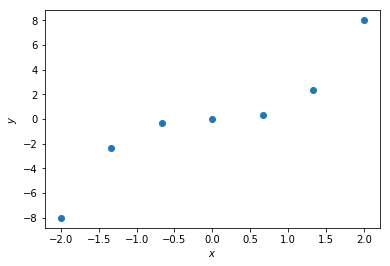

In [2]:
X = np.linspace(-2, 2, 7)
y = X ** 3 # original dependecy 

plt.scatter(X, y)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

In [7]:
print(X)

[-2.         -1.33333333 -0.66666667  0.          0.66666667  1.33333333
  2.        ]


Let's make several steps to build a decision tree. In the case of a **regression** task, at prediction time, the leaf returns the average value for all observations in this leaf.

Let's start with a tree of depth 0, i.e. all observations placed in a single leaf. 

<br>You'll need to build a tree with only one node (also called **root**) that contains all train observations (instances). 
<br>How will predictions of this tree look like for $x \in [-2, 2]$? <br> Create an appropriate plot using a pen, paper and Python if needed (but no `sklearn` is needed yet).

In [17]:
dtr = DecisionTreeRegressor(max_depth = 1)
train = X.reshape(-1,1)
dtr.fit(train, y)
out = dtr.predict(train)

print(out)



[-5.18518519 -5.18518519  2.07407407  2.07407407  2.07407407  2.07407407
  2.07407407]


**Making first splits.**
<br>Let's split the data according to the following condition $[x < 0]$. It gives us the tree of depth 1 with two leaves. To clarify, for all instances with $x \geqslant 0$ the tree will return some value, for all instances with $x < 0$ it will return another value. Let's create a similar plot for predictions of this tree.

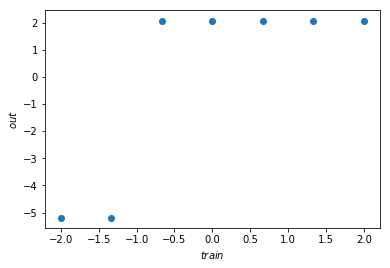

In [16]:
plt.scatter(train, out)
plt.xlabel(r'$train$')
plt.ylabel(r'$out$');

In the decision tree algorithm, the feature and the threshold for splitting are chosen according to some criterion. The commonly used criterion for regression is based on variance: $$\large Q(X, y, j, t) = D(X, y) - \dfrac{|X_l|}{|X|} D(X_l, y_l) - \dfrac{|X_r|}{|X|} D(X_r, y_r),$$
where $\large X$ and $\large y$ are a feature matrix and a target vector (correspondingly) for training instances in a current node, $\large X_l, y_l$ and $\large X_r, y_r$ are splits of samples $\large X, y$ into two parts w.r.t. $\large [x_j < t]$ (by $\large j$-th feature and threshold $\large t$), $\large |X|$, $\large |X_l|$, $\large |X_r|$ (or, the same, $\large |y|$, $\large |y_l|$, $\large |y_r|$) are sizes of appropriate samples, and $\large D(X, y)$ is variance of answers $\large y$ for all instances in $\large X$:
$$\large D(X, y) = \dfrac{1}{|X|} \sum_{j=1}^{|X|}(y_j – \dfrac{1}{|X|}\sum_{i = 1}^{|X|}y_i)^2$$
Here $\large y_i = y(x_i)$ is the answer for the $\large x_i$ instance. Feature index $\large j$ and threshold $\large t$ are chosen to maximize the value of criterion  $\large Q(X, y, j, t)$ for each split.

In our 1D case,  there's only one feature so $\large Q$ depends only on threshold $\large t$ and training data $\large X$ and $\large y$. Let's designate it $\large Q_{1d}(X, y, t)$ meaning that the criterion no longer depends on feature index $\large j$, i.e. in 1D case $\large j = 1$.

По большей части сверху - полная хуета.
i - строки, j - столбцы; 
Формула дисперсии = 1/(количество 

In [87]:
def D(X, y):
    if len(y) == 0:
        return 0
    y = np.array(y)
    y_avg = y.mean()
    summ = 0
    for y_j in y:
        summ += ((y_j - y_avg)**2)
    return summ/len(y)
    
def Divide(X, y, t):
    Xl = []
    Xr = []
    yl = []
    yr = []
    for i in range(len(y)):
        if X[i] < t:
            Xl.append(X[i])
            yl.append(y[i])
        else:
            Xr.append(X[i])
            yr.append(y[i])
    return np.array(Xl), np.array(yl), np.array(Xr), np.array(yr)

# t = порог разбиения? ну допустим
def regression_var_criterion(X, y, t):
    # делим выборку по порогу на 2 части
    X_l, y_l, X_r, y_r = Divide(X, y, t)
    # трижды вызываем D
    result = D(X,y) - (len(X_l)/len(X))*D(X_l, y_l) - (len(X_r)/len(X))*D(X_r, y_r)
    return result

In [58]:
X = np.linspace(1.9, -1.9, 20)
y = X**2
t = -1.3
X_l, y_l, X_r, y_r = Divide(X,y, t)
# print(X_l)
# print(y_l)
# print(X_r)
# print(y_r)

print(D(X,y))
print(D(X_l,y_l))
print(D(X_r,y_r))

q = regression_var_criterion(X, y, t)
print(q)

1.4044799999999995
0.3086222222222222
1.0752000000000004
0.4442666666666659


In [103]:
from sklearn.metrics import mean_absolute_error


X = np.linspace(-2, 2, 7)
y = X**3
Q = []
tlist =  np.linspace(-3, 3, 100)
for t in tlist:
    q = regression_var_criterion(X, y, t)
    Q.append(q)
#print(Q)


    
   

Create the plot of criterion $\large Q_{1d}(X, y, t)$  as a function of threshold value $t$ on the interval $\large [-1.9, 1.9]$.

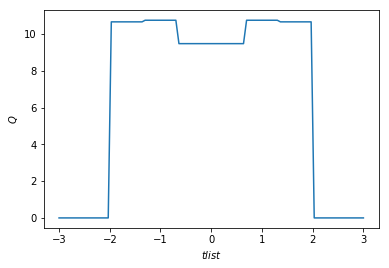

In [93]:
plt.plot(tlist, Q)
plt.xlabel(r'$tlist$')
plt.ylabel(r'$Q$');

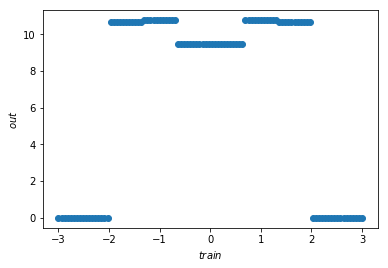

In [94]:
plt.scatter(tlist, Q)
plt.xlabel(r'$train$')
plt.ylabel(r'$out$');

In [95]:
tlist2 =  [-1.9, -1.3, 0, 1.3, 1.9]
Q2 = []
for t in tlist2:
    q = regression_var_criterion(X, y, t)
    Q2.append(q)
print(Q2)

[10.666666666666664, 10.754458161865568, 9.481481481481481, 10.754458161865566, 10.666666666666666]


**<font color='red'>Question 1.</font> What is the worst threshold value (to perform a split) according to the variance criterion?**

<font color = 'red'> **Answer options:** </font>
- -1.9
- -1.3
- 0
- 1.3
- 1.9 

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a2_part1_fall2019__*

this is 0

Then let's make splitting in each of the leaves nodes. 
<br> Take your tree with first threshold [$x<0$].
<br> Now add a split in the left branch (where previous split was $x < 0$) using the criterion $[x < -1.5]$, in the right branch (where previous split was $x \geqslant 0$) with the following criterion $[x < 1.5]$. 
<br>It gives us a tree of depth 2 with 7 nodes and 4 leaves. Create a plot of this tree predictions for $x \in [-2, 2]$.

In [117]:
X = np.linspace(-2, 2, 7)
y = X**3
t = 0
X_l, y_l, X_r, y_r = Divide(X,y, t)
t_l, t_r = -1.5, 1.5
# для левой части, у которой прокнуло что меньше 0, выберем порог x<-1.5
X_l_l, y_l_l, X_l_r, y_l_r = Divide(X_l,y_l, t_l)
#для правой - x<1.5
X_r_l, y_r_l, X_r_r, y_r_r = Divide(X_r,y_r, t_r)

# print(X, y, sep = '\n')
# print(X_l, y_l, sep = '\n')
# print(X_r, y_r, sep = '\n')
print('x=',X_l_l, 'y=',y_l_l, 't= x<', t_l, 'y.mean=', y_l_l.mean() )
print('x=',X_l_r, 'y=',y_l_r, 't= x>', t_l, 'y.mean=', y_l_r.mean()  )
print('x=',X_r_l, 'y=',y_r_l, 't= x<', t_r, 'y.mean=', y_r_l.mean()  )
print('x=',X_r_r, 'y=',y_r_r, 't= x>', t_r, 'y.mean=', y_r_r.mean()  )


x= [-2.] y= [-8.] t= x< -1.5 y.mean= -8.0
x= [-1.33333333 -0.66666667] y= [-2.37037037 -0.2962963 ] t= x> -1.5 y.mean= -1.3333333333333337
x= [0.         0.66666667 1.33333333] y= [0.         0.2962963  2.37037037] t= x< 1.5 y.mean= 0.8888888888888884
x= [2.] y= [8.] t= x> 1.5 y.mean= 8.0


In [119]:
def y_x(x):
    result = 0
    if x<-1.5:
        result = y_l_l.mean()
    elif x<0:
        result = y_l_r.mean()
    elif x<1.5:
        result = y_r_l.mean()
    elif x>1.5:
        result = y_r_r.mean()
    return result

y2 = []
for x in X:
    y_i = y_x(x)
    y2.append(y_i)
print(X)
print(y2)
    

[-2.         -1.33333333 -0.66666667  0.          0.66666667  1.33333333
  2.        ]
[-8.0, -1.3333333333333337, -1.3333333333333337, 0.8888888888888884, 0.8888888888888884, 0.8888888888888884, 8.0]


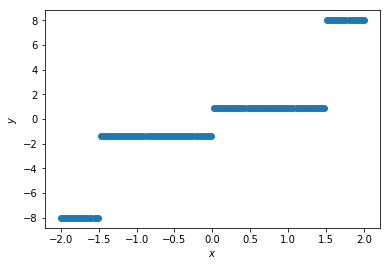

In [124]:
X3 = np.linspace(-2, 2, 100)
y3 = [y_x(x) for x in X3] 
plt.scatter(X3, y3)
plt.xlabel(r'$x$')
plt.ylabel(r'$y$');

**<font color='red'>Question 2.</font> Tree predictions is a piecewise-constant function, right? How many "pieces" (horizontal segments in the plot that you've just built) are there in the interval [-2, 2]?**

<font color = 'red'> **Answer options:** </font>
- 2
- 4
- 6
- 8

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a2_part1_fall2019__*

4 there

## 2. Building a decision tree for predicting heart diseases
Let's read the data on heart diseases. The dataset can be downloaded from the course repo from [here](https://github.com/Yorko/mlcourse.ai/blob/master/data/mlbootcamp5_train.csv) by clicking on `Download` and then selecting `Save As` option. If you work with Git, then the dataset is already there in `data/mlbootcamp5_train.csv`.

**Problem**

Predict presence or absence of cardiovascular disease (CVD) using the patient examination results.

**Data description**

There are 3 types of input features:

- *Objective*: factual information;
- *Examination*: results of medical examination;
- *Subjective*: information given by the patient.

| Feature | Variable Type | Variable      | Value Type |
|---------|--------------|---------------|------------|
| Age | Objective Feature | age | int (days) |
| Height | Objective Feature | height | int (cm) |
| Weight | Objective Feature | weight | float (kg) |
| Gender | Objective Feature | gender | categorical code |
| Systolic blood pressure | Examination Feature | ap_hi | int |
| Diastolic blood pressure | Examination Feature | ap_lo | int |
| Cholesterol | Examination Feature | cholesterol | 1: normal, 2: above normal, 3: well above normal |
| Glucose | Examination Feature | gluc | 1: normal, 2: above normal, 3: well above normal |
| Smoking | Subjective Feature | smoke | binary |
| Alcohol intake | Subjective Feature | alco | binary |
| Physical activity | Subjective Feature | active | binary |
| Presence or absence of cardiovascular disease | Target Variable | cardio | binary |

All of the dataset values were collected at the moment of medical examination.

In [29]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')

In [30]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Transform the features: 
- create "age in years" dividing age by 365.25 and taking floor ($\lfloor{x}\rfloor$ is the largest integer that is less than or equal to $x$) 
- create 3 binary features based on `cholesterol`.
- create 3 binary features based on `gluc`.
<br> Binary features equal to 1, 2 or 3. This method is called dummy-encoding or One Hot Encoding (OHE). It is more convenient to use `pandas.get_dummies`. There is no need to use the original features `cholesterol` and `gluc` after encoding.

In [31]:
import math
# функция для годов
def day_to_year(days):
    return math.floor(days/365.25)

# возраст в года
df['age'] = df['age'].apply(day_to_year)


In [32]:
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,50,2,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,51,1,165,64.0,130,70,3,1,0,0,0,1
3,48,2,169,82.0,150,100,1,1,0,0,1,1
4,47,1,156,56.0,100,60,1,1,0,0,0,0


In [33]:
def feature_to_3_classes(dataFrame, featureName):
    dataFrame['Low_'+featureName] = (dataFrame[featureName] == 1).astype('int')
    dataFrame['Med_'+featureName] = (dataFrame[featureName] == 2).astype('int')
    dataFrame['High_'+featureName] = (dataFrame[featureName] == 3).astype('int')
    dataFrame = dataFrame.drop([featureName], axis=1)

feature_to_3_classes(df, 'cholesterol')
feature_to_3_classes(df, 'gluc')
df = df.drop(['cholesterol', 'gluc'], axis = 1)

df.head()
# gluc в 3 фичи

,age,gender,height,weight,ap_hi,ap_lo,smoke,alco,active,cardio,Low_cholesterol,Med_cholesterol,High_cholesterol,Low_gluc,Med_gluc,High_gluc
id,,,,,,,,,,,,,,,,
0,50,2,168,62.0,110,80,0,0,1,0,1,0,0,1,0,0
1,55,1,156,85.0,140,90,0,0,1,1,0,0,1,1,0,0
2,51,1,165,64.0,130,70,0,0,0,1,0,0,1,1,0,0
3,48,2,169,82.0,150,100,0,0,1,1,1,0,0,1,0,0
4,47,1,156,56.0,100,60,0,0,0,0,1,0,0,1,0,0


Split data into train and holdout parts in the proportion of 7/3 using `sklearn.model_selection.train_test_split` with `random_state=17`.

In [34]:
from sklearn.model_selection import train_test_split
y = df['cardio']
df = df.drop(['cardio'], axis = 1)
X_train, X_valid, y_train, y_valid = train_test_split(df.values, y, test_size=0.3,random_state=17)

Train a decision tree on the dataset `(X_train, y_train)` with **max depth equal to 3** and `random_state=17`. Plot this tree with `sklearn.tree.export_graphviz` and Graphviz. Here we need to mention that `sklearn` doesn't draw decision trees on its own, but is able to output a tree in the `.dot` format that can be used by Graphviz for visualization. 

How to plot a decision tree, alternatives:
 1. Install Graphviz and pydotpus yourself (see below)
 2. Use our docker image with all needed packages already installed
 3. Easy way: execute `print(dot_data.getvalue())` with `dot_data` defined below (this can be done without pydotplus and Graphviz), go to http://www.webgraphviz.com, paste the graph code string (digraph Tree {...) and generate a nice picture

There are may be some troubles with graphviz for Windows users.
The error is 'GraphViz's executables not found'.
<br>To fix that - install Graphviz from [here](https://graphviz.gitlab.io/_pages/Download/Download_windows.html).
<br>Then add graphviz path to your system PATH variable. You can do this manually, but don't forget to restart kernel.
<br>Or just run this code:

In [35]:
import os
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
path_to_graphviz = '' # your path to graphviz (C:\\Program Files (x86)\\Graphviz2.38\\bin\\ for example) 
os.environ["PATH"] += os.pathsep + path_to_graphviz

In [36]:
dtc = DecisionTreeClassifier(max_depth = 3, random_state = 17)
dtc.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=17,
            splitter='best')

In [37]:
import pydotplus #pip install pydotplus
from sklearn.tree import export_graphviz

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    tree_str = export_graphviz(tree, feature_names=feature_names, 
                                     filled=True, out_file=None)
    graph = pydotplus.graph_from_dot_data(tree_str)  
    graph.write_png(png_file_to_save)

In [38]:

print(df_fnames)

['age', 'gender', 'height', 'weight', 'ap_hi', 'ap_lo', 'smoke', 'alco', 'active', 'Low_cholesterol', 'Med_cholesterol', 'High_cholesterol', 'Low_gluc', 'Med_gluc', 'High_gluc']


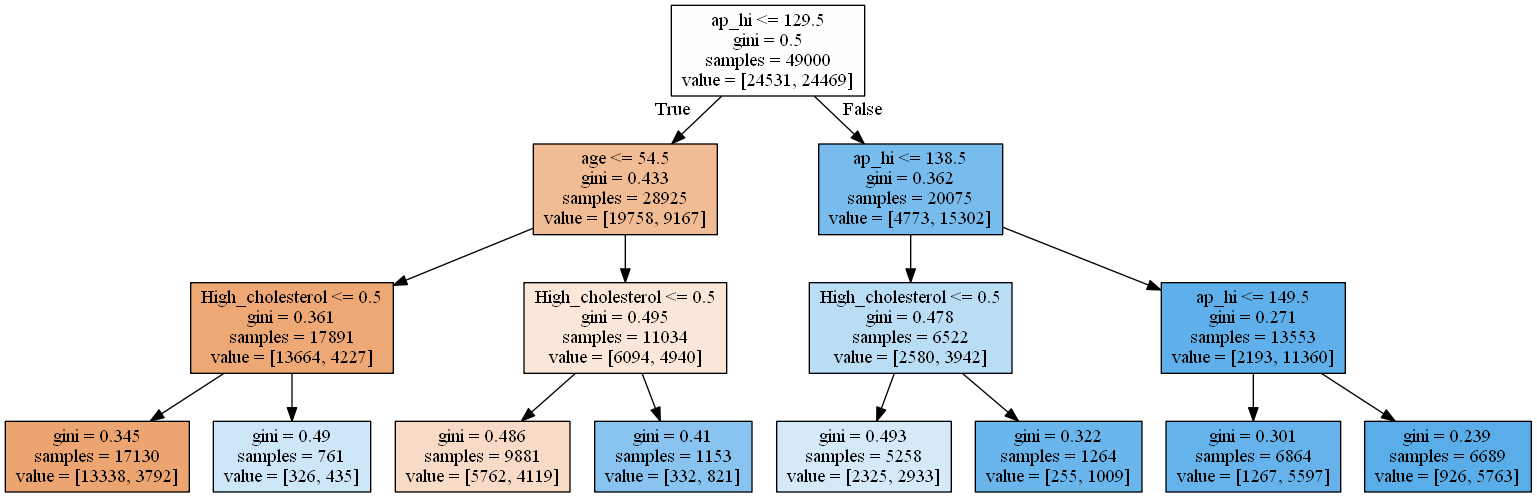

In [39]:
from IPython.display import Image
df_fnames = list(df)
path = '../../img/topic3_decision_tree1.png'
tree_graph_to_png(tree=dtc, feature_names=df_fnames, 
                  png_file_to_save=path)
Image(filename=path)

Take a look how trees are visualized in the [3rd part](https://nbviewer.jupyter.org/github/Yorko/mlcourse_open/blob/master/jupyter_english/topic03_decision_trees_kNN/topic3_decision_trees_kNN.ipynb?flush_cache=true) of course materials.

**<font color='red'>Question 3.</font> Which 3 features are used to make predictions in the created decision tree?**

<font color = 'red'> **Answer options:** </font>
- age, ap_lo, chol=1
- age, ap_hi, chol=3
- smoke, age, gender
- alco, weight, gluc=3

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a2_part1_fall2019__*

age, ap_hi, chol=3

Make predictions for holdout data `(X_valid, y_valid)` with the trained decision tree. Calculate accuracy.

In [40]:
X_valid.head()

AttributeError: 'numpy.ndarray' object has no attribute 'head'

In [41]:
from sklearn.metrics import roc_auc_score,accuracy_score
y_pred = dtc.predict(X_valid)
acc = accuracy_score(y_valid, y_pred)
print(acc)

0.7212857142857143


Set up the depth of the tree using cross-validation on the dataset `(X_train, y_train)` in order to increase quality of the model. Use `GridSearchCV` with 5 folds. Fix `random_state=17` and change  `max_depth` from 2 to 10.

In [42]:
tree_params = {'max_depth': list(range(2, 11))}

tree_grid = GridSearchCV(dtc, tree_params,
                         cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)
tree_grid.best_params_

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    6.7s finished


{'max_depth': 6}

Draw the plot to show how mean accuracy is changing in regards to `max_depth` value on cross-validation.

In [49]:
ACCarr, MD_arr = [], []
for md in range(2, 11):
    dtn = DecisionTreeClassifier(max_depth = md, random_state = 17)
    dtn.fit(X_train, y_train)
    y_pred_new = dtn.predict(X_valid)
    acc = accuracy_score(y_valid, y_pred_new)
    ACCarr.append(acc)
    MD_arr.append(md)
print(max(ACCarr))

0.7284285714285714


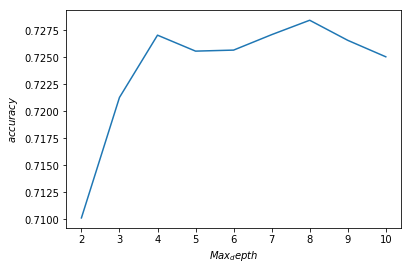

In [48]:
plt.plot(MD_arr,ACCarr)
plt.xlabel(r'$Max_depth$')
plt.ylabel(r'$accuracy$');

Print the best value of `max_depth` where the mean value of cross-validation quality metric reaches maximum. Also compute accuracy on holdout data. This can be done with the trained instance of the class `GridSearchCV`.

In [16]:
# You code here

Сalculate the effect of `GridSearchCV`: check out the expression (acc2 - acc1) / acc1 * 100%, where acc1 and acc2 are accuracies on holdout data before and after tuning max_depth with GridSearchCV respectively.

**<font color='red'>Question 4.</font> Choose all correct statements.**

<font color = 'red'> **Answer options:** </font>

- There exists a local maximum of accuracy on the built validation curve
- `GridSearchCV` increased holdout accuracy by **more** than 1%
- There is **no** local maximum of accuracy on the built validation curve
- `GridSearchCV` increased holdout accuracy by **less** than 1%

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a2_part1_fall2019__*

1, 4 - верные

Take a look at the SCORE table to estimate ten-year risk of fatal cardiovascular disease in Europe. [Source paper](https://academic.oup.com/eurheartj/article/24/11/987/427645).

<img src='../../img/SCORE2007-eng.png' width=70%>

Let's create new features according to this picture:
- $age \in [40,50), age \in [50,55), age \in [55,60), age \in [60,65) $ (4 features)
- systolic blood pressure: $ap\_hi \in [120,140), ap\_hi \in [140,160), ap\_hi \in [160,180),$ (3 features)

If the values of age or blood pressure don't fall into any of the intervals then all binary features will be equal to zero. 

<br>Add a ``smoke`` feature.
<br>Build the ``cholesterol``  and ``gender`` features. Transform the ``cholesterol`` to 3 binary features according to it's 3 unique values ( ``cholesterol``=1,  ``cholesterol``=2 and  ``cholesterol``=3). Transform the ``gender`` from 1 and 2 into 0 and 1. It is better to rename it to ``male`` (0 – woman, 1 – man). In general, this is typically done with ``sklearn.preprocessing.LabelEncoder`` but here in case of only 2 unique values it's not necessary.

Finally, the decision tree is built using these 12 binary features (excluding all original features that we had before this feature engineering part).

Create a decision tree with the limitation `max_depth=3` and train it on the whole train data. Use the `DecisionTreeClassifier` class with fixed `random_state=17`, but all other arguments (except for `max_depth` and `random_state`) should be left with their default values.

**<font color='red'>Question 5.</font> Which binary feature is the most important for heart disease detection (i.e., it is placed in the root of the tree)?**

<font color = 'red'> **Answer options:** </font>

- Systolic blood pressure from 160 to 180 (mmHg)
- Cholesterol level == 3
- Systolic blood pressure from 140 to 160 (mmHg)
- Age from 50 to 55 (years)
- Smokes / doesn't smoke
- Age from 60 to 65 (years)

*For discussions, please stick to [ODS Slack](https://opendatascience.slack.com/), channel __#mlcourse_ai_news__, pinned thread __#a2_part1_fall2019__*

- Systolic blood pressure from 140 to 160 (mmHg)

In [105]:
df = pd.read_csv('../../data/mlbootcamp5_train.csv', 
                 index_col='id', sep=';')
df.head()

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [106]:
# возраст в года
df['year'] = df['age'].apply(day_to_year)

# года в 4 промежутка
df['Years from 40 to 49'] = ((df['year'] >=40) & (df['year'] <50)).astype('int')
df['Years from 50 to 54'] = ((df['year'] >=50) & (df['year'] <55)).astype('int')
df['Years from 55 to 59'] = ((df['year'] >=55) & (df['year'] <60)).astype('int')
df['Years from 60 to 64'] = ((df['year'] >=60) & (df['year'] <65)).astype('int')
df = df.drop('age', axis =1)
df = df.drop('year', axis =1)

#systolic blood pressure:  𝑎𝑝_ℎ𝑖∈[120,140),𝑎𝑝_ℎ𝑖∈[140,160),𝑎𝑝_ℎ𝑖∈[160,180),  (3 features)
df['Systolic blood  [120,140)'] = ((df['ap_hi'] >=120) & (df['ap_hi'] <140)).astype('int')
df['Systolic blood [140,160)'] = ((df['ap_hi'] >=140) & (df['ap_hi'] <160)).astype('int')
df['Systolic blood [160,180)'] = ((df['ap_hi'] >=160) & (df['ap_hi'] <180)).astype('int')
df = df.drop('ap_hi', axis =1)

#Build the cholesterol
feature_to_3_classes(df, 'cholesterol')
df = df.drop('cholesterol', axis =1)

#build male
df['male'] = df['gender'].map({1: 0, 2: 1})
df = df.drop(['gender','weight', 'height', 'ap_lo' , 'gluc', 'alco', 'active'], axis = 1)
df.head()

,smoke,cardio,Years from 40 to 49,Years from 50 to 54,Years from 55 to 59,Years from 60 to 64,"Systolic blood [120,140)","Systolic blood [140,160)","Systolic blood [160,180)",Low_cholesterol,Med_cholesterol,High_cholesterol,male
id,,,,,,,,,,,,,
0,0,0,0,1,0,0,0,0,0,1,0,0,1
1,0,1,0,0,1,0,0,1,0,0,0,1,0
2,0,1,0,1,0,0,1,0,0,0,0,1,0
3,0,1,1,0,0,0,0,1,0,1,0,0,1
4,0,0,1,0,0,0,0,0,0,1,0,0,0


In [107]:
y = df['cardio']
df = df.drop('cardio', axis=1)
# исключить остальные фичи из набора и проверить, не изменится ли дерево

X_train, X_valid, y_train, y_valid = train_test_split(df.values, y, test_size=0.3,random_state=17)




In [108]:
df_last = DecisionTreeClassifier(max_depth=3, random_state = 17)
df_last.fit(X_train, y_train)
last_predictions = df_last.predict(X_valid)
ac_last = accuracy_score(y_valid, last_predictions)
print(ac_last)

0.704047619047619


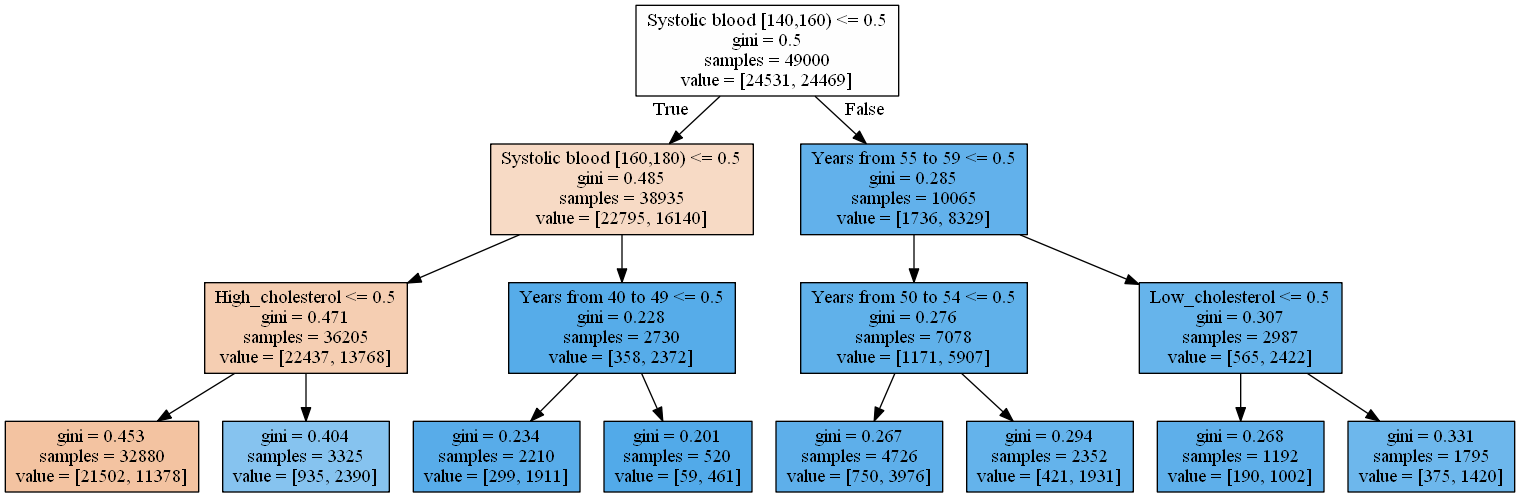

In [109]:

df_fnames = list(df)
path = '../../img/topic3_decision_tree_ass_last.png'
tree_graph_to_png(tree=df_last, feature_names=df_fnames, 
                  png_file_to_save=path)
Image(filename=path)